In [ ]:
import os
import math
#!pip install scikitplot
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import tree
from scipy.stats import randint
from scipy.stats import loguniform
from IPython.display import display

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

In [ ]:
df = pd.read_csv('insurance2.csv')

target = 'insuranceclaim'
labels = ['Claimed',
          'Not Claimed']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1



Inference: The Datset consists of 8 features & 1338 samples.


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             1338 non-null   int64  
 1   sex             1338 non-null   int64  
 2   bmi             1338 non-null   float64
 3   children        1338 non-null   int64  
 4   smoker          1338 non-null   int64  
 5   region          1338 non-null   int64  
 6   charges         1338 non-null   float64
 7   insuranceclaim  1338 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 83.8 KB


In [ ]:
df.nunique().sort_values()


sex                  2
smoker               2
insuranceclaim       2
region               4
children             6
age                 47
bmi                548
charges           1337
dtype: int64

In [ ]:
nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0;

for i in range(df[features].shape[1]):
    if nu.values[i]<=7:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 3 numerical & 4 categorical features.


In [ ]:
display(df.describe())


,age,sex,bmi,children,smoker,region,charges,insuranceclaim
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265,0.585202
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.104885,12110.011237,0.492871
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287150,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000,1.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,2.000000,16639.912515,1.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010,1.000000


# Preprocessing

In [ ]:
#Removal of any Duplicate rows

counter = 0
r,c = original_df.shape

df1 = df.copy()
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True,inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped ---> 1


In [ ]:
#Check for empty elements

nvc = pd.DataFrame(df1.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df1.shape[0],3)*100
print(nvc)

                Total Null Values  Percentage
age                             0         0.0
sex                             0         0.0
bmi                             0         0.0
children                        0         0.0
smoker                          0         0.0
region                          0         0.0
charges                         0         0.0
insuranceclaim                  0         0.0


In [ ]:
#Converting categorical Columns to Numeric

ecc = nvc[nvc['Percentage']!=0].index.values
dcc = [i for i in df.columns if i not in ecc]

df3 = df1[dcc]
fcc = [i for i in cf if i not in ecc]

#One-Hot Binary Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1m\nOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape



One-Hot Encoding on features:
sex
smoker

Dummy Encoding on features:
region
children


(1337, 14)

In [ ]:
#Removal of outlier:

df4 = df3.copy()

for i in [i for i in df4.columns]:
    if df4[i].nunique()>=12:
        Q1 = df4[i].quantile(0.25)
        Q3 = df4[i].quantile(0.75)
        IQR = Q3 - Q1
        df4 = df4[df4[i] <= (Q3+(1.5*IQR))]
        df4 = df4[df4[i] >= (Q1-(1.5*IQR))]
df4 = df4.reset_index(drop=True)
display(df4.head())
print('\n\033[1mInference:\033[0m Before removal of outliers, The dataset had {} samples.'.format(df1.shape[0]))
print('\033[1mInference:\033[0m After removal of outliers, The dataset now has {} samples.'.format(df4.shape[0]))

,age,sex,bmi,smoker,charges,insuranceclaim,region_1,region_2,region_3,children_1,children_2,children_3,children_4,children_5
0,19,False,27.900,True,16884.92400,1,False,False,True,False,False,False,False,False
1,18,True,33.770,False,1725.55230,1,False,True,False,True,False,False,False,False
2,28,True,33.000,False,4449.46200,0,False,True,False,False,False,True,False,False
3,33,True,22.705,False,21984.47061,0,True,False,False,False,False,False,False,False
4,32,True,28.880,False,3866.85520,1,True,False,False,False,False,False,False,False



Inference: Before removal of outliers, The dataset had 1337 samples.
Inference: After removal of outliers, The dataset now has 1190 samples.


In [ ]:
df5 = df4.copy()

print('Original class distribution:')
print(df5[target].value_counts())

xf = df5.columns
X = df5.drop([target],axis=1)
Y = df5[target]

smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

df5 = pd.DataFrame(X, columns=xf)
df5[target] = Y

print('\nClass distribution after applying SMOTE Technique:',)
print(Y.value_counts())

Original class distribution:
insuranceclaim
1    638
0    552
Name: count, dtype: int64

Class distribution after applying SMOTE Technique:
insuranceclaim
1    638
0    638
Name: count, dtype: int64


# Data Manipulation

In [ ]:

df = df5.copy()

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (1276, 13) (1276,) 
Training set  --->  (1020, 13) (1020,) 
Testing set   --->  (256, 13)  (256,)


In [ ]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,age,sex,bmi,smoker,charges,region_1,region_2,region_3,children_1,children_2,children_3,children_4,children_5
count,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03,1.020000e+03
mean,2.394599e-16,6.269495e-17,-1.071039e-16,-7.053182e-17,1.288729e-16,1.140700e-16,-2.612289e-18,1.741526e-17,-2.612289e-17,-1.219068e-17,-5.224579e-18,4.005511e-17,2.786442e-17
std,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00,1.000491e+00
min,-1.490292e+00,-1.015811e+00,-2.387821e+00,-3.494456e-01,-1.203959e+00,-6.075587e-01,-5.818786e-01,-5.743314e-01,-5.924469e-01,-4.938648e-01,-3.737175e-01,-1.518855e-01,-1.340301e-01
25%,-9.129940e-01,-1.015811e+00,-7.262911e-01,-3.494456e-01,-7.538793e-01,-6.075587e-01,-5.818786e-01,-5.743314e-01,-5.924469e-01,-4.938648e-01,-3.737175e-01,-1.518855e-01,-1.340301e-01
50%,2.511529e-02,9.844348e-01,-3.923232e-02,-3.494456e-01,-2.288789e-01,-6.075587e-01,-5.818786e-01,-5.743314e-01,-5.924469e-01,-4.938648e-01,-3.737175e-01,-1.518855e-01,-1.340301e-01
75%,8.189001e-01,9.844348e-01,6.509471e-01,-3.494456e-01,3.993038e-01,1.645932e+00,1.718572e+00,-5.743314e-01,1.687915e+00,-4.938648e-01,-3.737175e-01,-1.518855e-01,-1.340301e-01
max,1.829172e+00,9.844348e-01,2.925278e+00,2.861676e+00,3.418978e+00,1.645932e+00,1.718572e+00,1.741155e+00,1.687915e+00,2.024846e+00,2.675818e+00,6.583907e+00,7.461010e+00



                                Standardardization on Testing set                                


,age,sex,bmi,smoker,charges,region_1,region_2,region_3,children_1,children_2,children_3,children_4,children_5
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,0.041465,-0.054756,0.058199,0.026858,-0.021859,-0.070594,0.101068,0.076899,0.039997,-0.051123,0.078948,-0.099262,-0.045026
std,1.019556,1.001317,1.019761,1.034860,0.943853,0.961940,1.053091,1.043103,1.022890,0.960585,1.086335,0.594197,0.818957
min,-1.490292,-1.015811,-1.863241,-0.349446,-1.201232,-0.607559,-0.581879,-0.574331,-0.592447,-0.493865,-0.373718,-0.151886,-0.134030
25%,-0.858872,-1.015811,-0.689838,-0.349446,-0.769641,-0.607559,-0.581879,-0.574331,-0.592447,-0.493865,-0.373718,-0.151886,-0.134030
50%,0.025115,-1.015811,0.000330,-0.349446,-0.192925,-0.607559,-0.581879,-0.574331,-0.592447,-0.493865,-0.373718,-0.151886,-0.134030
75%,0.963225,0.984435,0.713716,-0.349446,0.445745,-0.607559,1.718572,1.741155,1.687915,-0.493865,-0.373718,-0.151886,-0.134030
max,1.829172,0.984435,2.887315,2.861676,3.303173,1.645932,1.718572,1.741155,1.687915,2.024846,2.675818,6.583907,7.461010


# Feature Scaling

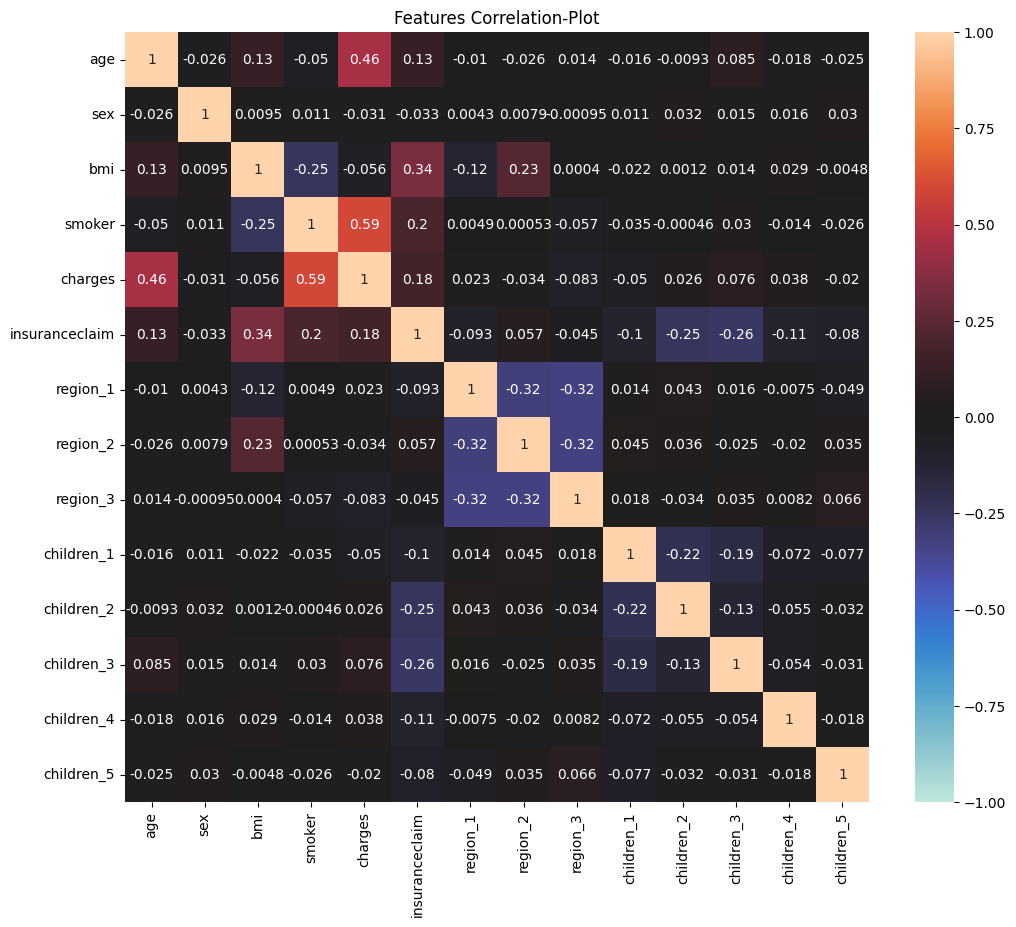

In [ ]:
#Checking the correlation

features = df.columns
plt.figure(figsize=[12,10])
plt.title('Features Correlation-Plot')
sns.heatmap(df[features].corr(), vmin=-1, vmax=1, center=0, annot=True) #,
plt.show()

# Predictive Modelling

In [ ]:

Evaluation_Results = pd.DataFrame(np.zeros((8,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)', 'Gradient Boosting (GB)','Extreme Gradient Boosting (XGB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0
Gradient Boosting (GB),0.0,0.0,0.0,0.0,0.0
Extreme Gradient Boosting (XGB),0.0,0.0,0.0,0.0,0.0


In [ ]:
#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob[:,1], multi_class='ovr'),3)*100 #[:, 1]
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))

    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Models

### Logistic Regression

In [ ]:
!pip install scikit-plot

In [ ]:
Evaluation_Results = pd.DataFrame(np.zeros((8,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])

In [ ]:
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)',
                         'Support Vector Machine (SVM)','K Nearest Neighbours (KNN)', 'Gradient Boosting (GB)','Extreme Gradient Boosting (XGB)']

In [ ]:
Evaluation_Results


,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0
Support Vector Machine (SVM),0.0,0.0,0.0,0.0,0.0
K Nearest Neighbours (KNN),0.0,0.0,0.0,0.0,0.0
Gradient Boosting (GB),0.0,0.0,0.0,0.0,0.0
Extreme Gradient Boosting (XGB),0.0,0.0,0.0,0.0,0.0


<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 83.2%
F1 Score = 83.2%

 Confusiton Matrix:
 [[101  23]
 [ 20 112]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.81      0.82       124
           1       0.83      0.85      0.84       132

    accuracy                           0.83       256
   macro avg       0.83      0.83      0.83       256
weighted avg       0.83      0.83      0.83       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


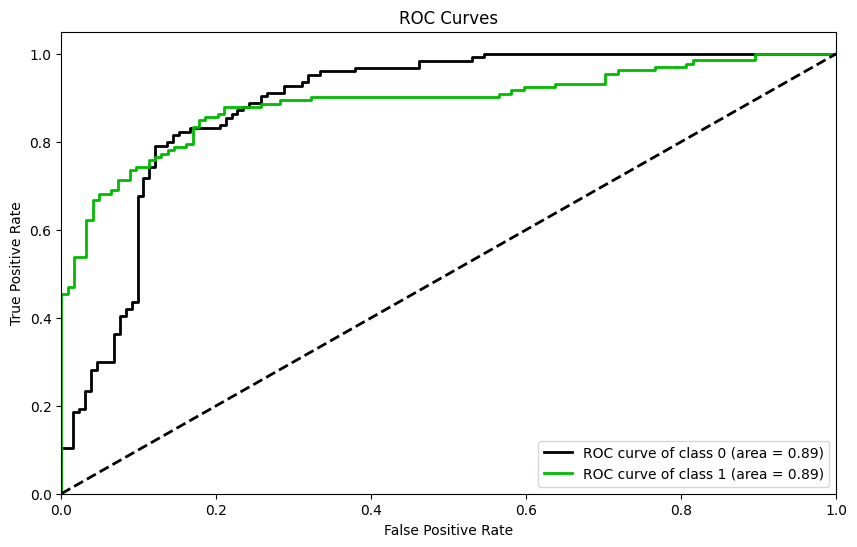


Interpreting the Output of Logistic Regression:

intercept  -0.050946228734332105
classes [0 1]


,coeff
age,0.451931
sex,-0.111802
bmi,1.607184
smoker,1.268280
charges,-0.080359
region_1,-0.263878
region_2,-0.180160
region_3,-0.206922
children_1,-0.919527
children_2,-1.335303


In [ ]:
LR_model = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = loguniform(1e-5, 100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
RCV = RandomizedSearchCV(LR_model, space, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

LR = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = LR.predict(Test_X_std)
pred_prob = LR.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,0)

print('\n\033[1mInterpreting the Output of Logistic Regression:\n\033[0m')

print('intercept ', LR.intercept_[0])
print('classes', LR.classes_)
display(pd.DataFrame({'coeff': LR.coef_[0]}, index=Train_X_std.columns))

### Decsion Tree Clasifier

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 96.5%
F1 Score = 96.5%

 Confusiton Matrix:
 [[120   4]
 [  5 127]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96       124
           1       0.97      0.96      0.97       132

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


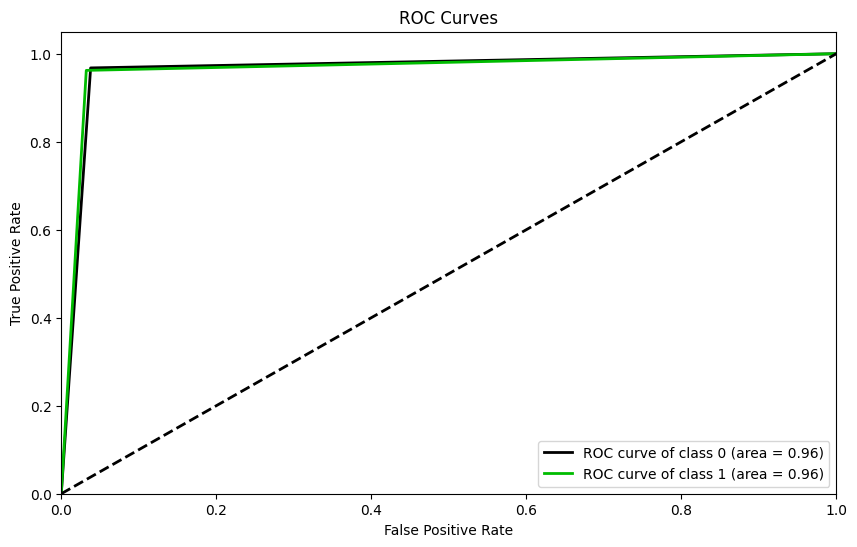


Interpreting the output of Decision Tree:



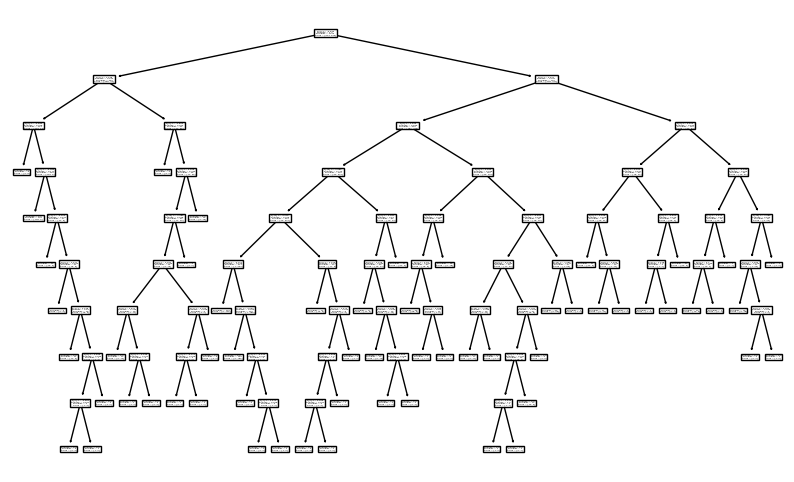

In [ ]:
#Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, len(features)-1),
              "min_samples_leaf": randint(1, len(features)-1),
              "criterion": ["gini", "entropy"]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(DT_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

DT = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = DT.predict(Test_X_std)
pred_prob = DT.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,1)

print('\n\033[1mInterpreting the output of Decision Tree:\n\033[0m')
tree.plot_tree(DT)
plt.show()

### Random Forest Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 92.60000000000001%
F1 Score = 92.60000000000001%

 Confusiton Matrix:
 [[120   4]
 [ 15 117]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       124
           1       0.97      0.89      0.92       132

    accuracy                           0.93       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.93      0.93      0.93       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


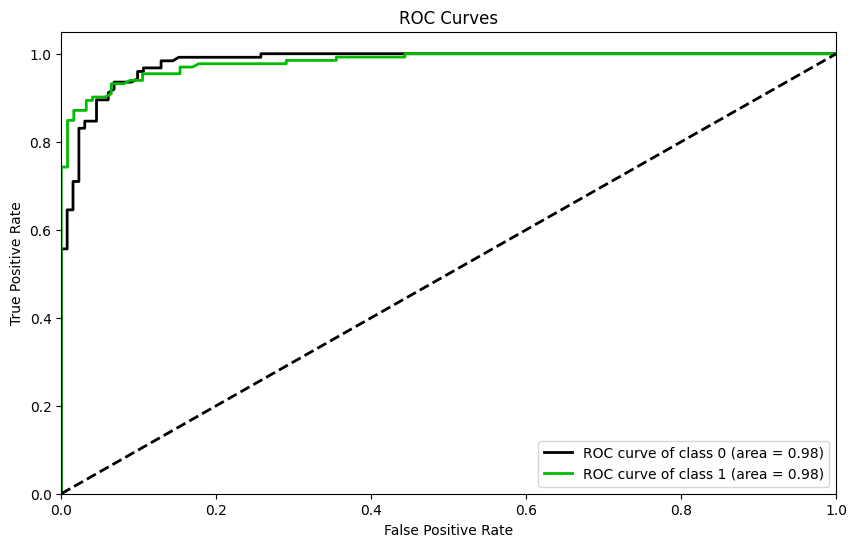


Interpreting the output of Random Forest:



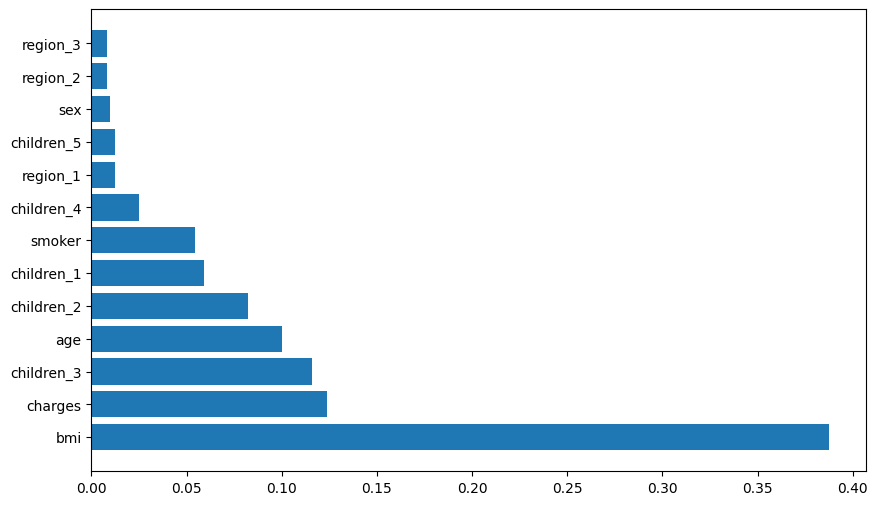

In [ ]:
#Random-Forest Classifier

RF_model = RandomForestClassifier()

param_dist={'bootstrap': [True, False],
            'max_depth': [10, 20, 50, 100, None],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [50, 100]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(RF_model, param_dist, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

RF = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = RF.predict(Test_X_std)
pred_prob = RF.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,2)

print('\n\033[1mInterpreting the output of Random Forest:\n\033[0m')
rfi=pd.Series(RF.feature_importances_, index=Train_X_std.columns).sort_values(ascending=False)
plt.barh(rfi.index,rfi.values)
plt.show()


### Naive Bayes Classification

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 77.0%
F1 Score = 76.9%

 Confusiton Matrix:
 [[ 92  32]
 [ 27 105]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76       124
           1       0.77      0.80      0.78       132

    accuracy                           0.77       256
   macro avg       0.77      0.77      0.77       256
weighted avg       0.77      0.77      0.77       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


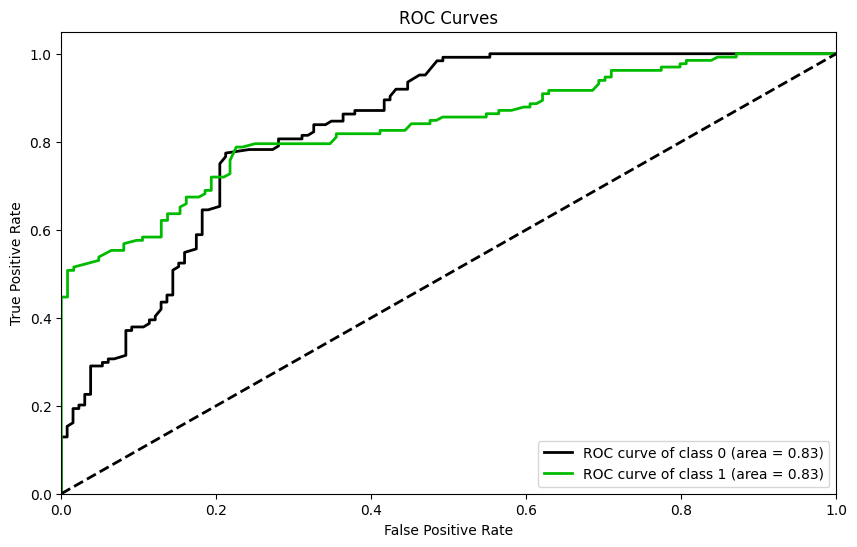

In [ ]:
#Naive Bayes Classifier

NB_model = BernoulliNB()

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(NB_model, params, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

NB = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = NB.predict(Test_X_std)
pred_prob = NB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,3)

### SVM Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


<<<----------------------------------- Evaluating Support Vector Machine (SVM) ----------------------------------->>>

Accuracy = 87.1%
F1 Score = 87.1%

 Confusiton Matrix:
 [[110  14]
 [ 19 113]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       124
           1       0.89      0.86      0.87       132

    accuracy                           0.87       256
   macro avg       0.87      0.87      0.87       256
weighted avg       0.87      0.87      0.87       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


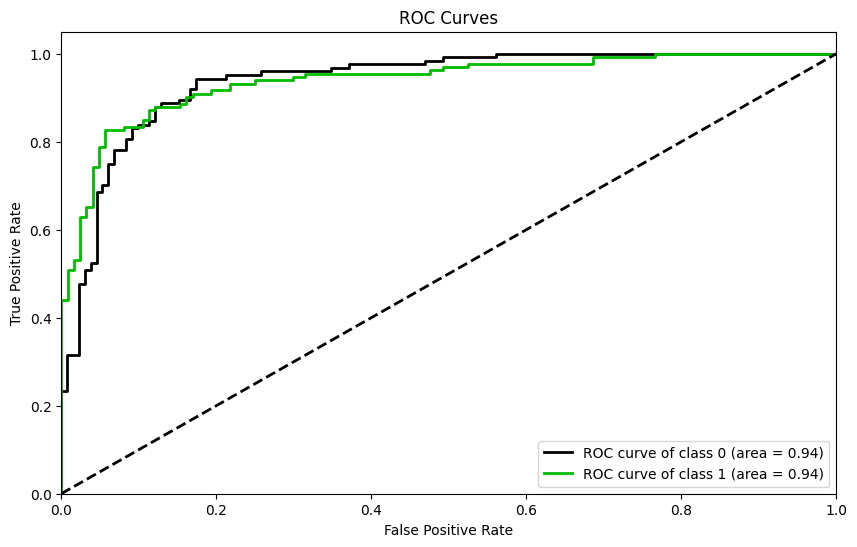

In [ ]:
 #Support Vector Machine Classifier

SVM_model = SVC(probability=True).fit(Train_X_std, Train_Y)

svm_param = {"C": [.01, .1, 1, 5, 10, 100],
             "gamma": [.01, .1, 1, 5, 10, 100],
             "kernel": ["rbf"],
             "random_state": [1]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(SVM_model, svm_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

SVM = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = SVM.predict(Test_X_std)
pred_prob = SVM.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,4)

### KNN Clasifier

<<<----------------------------------- Evaluating K Nearest Neighbours (KNN) ----------------------------------->>>

Accuracy = 86.3%
F1 Score = 86.3%

 Confusiton Matrix:
 [[107  17]
 [ 18 114]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       124
           1       0.87      0.86      0.87       132

    accuracy                           0.86       256
   macro avg       0.86      0.86      0.86       256
weighted avg       0.86      0.86      0.86       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


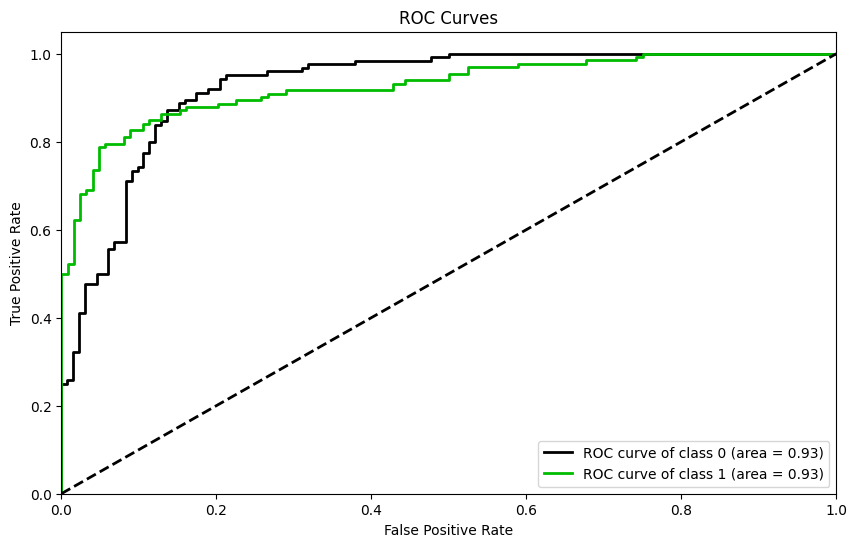

In [ ]:
#K-Neareset Neighbours Classifier

KNN_model = KNeighborsClassifier()

knn_param = {"n_neighbors": [i for i in range(1,30,5)],
             "weights": ["uniform", "distance"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "leaf_size": [1, 10, 30],
             "p": [1,2]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

RCV = RandomizedSearchCV(KNN_model, knn_param, n_iter=50, scoring='roc_auc', n_jobs=-1, cv=5, random_state=1)

KNN = RCV.fit(Train_X_std, Train_Y).best_estimator_
pred = KNN.predict(Test_X_std)
pred_prob = KNN.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,5)


### Gradient Boost Classfier

<<<----------------------------------- Evaluating Gradient Boosting (GB) ----------------------------------->>>

Accuracy = 93.8%
F1 Score = 93.8%

 Confusiton Matrix:
 [[117   7]
 [  9 123]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       124
           1       0.95      0.93      0.94       132

    accuracy                           0.94       256
   macro avg       0.94      0.94      0.94       256
weighted avg       0.94      0.94      0.94       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


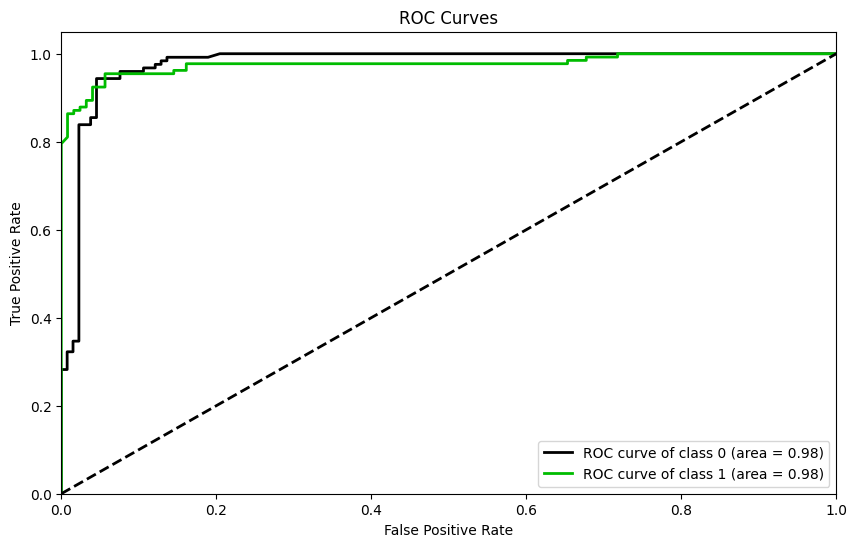

In [ ]:
#Gradient Boosting Classifier
GB_model = GradientBoostingClassifier().fit(Train_X_std, Train_Y)
param_dist = {
    "n_estimators":[5,20,100,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

GB = GB_model.fit(Train_X_std, Train_Y)#.best_estimator_
pred = GB.predict(Test_X_std)
pred_prob = GB.predict_proba(Test_X_std)
Classification_Summary(pred,pred_prob,6)


### XGBoost Classifier


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


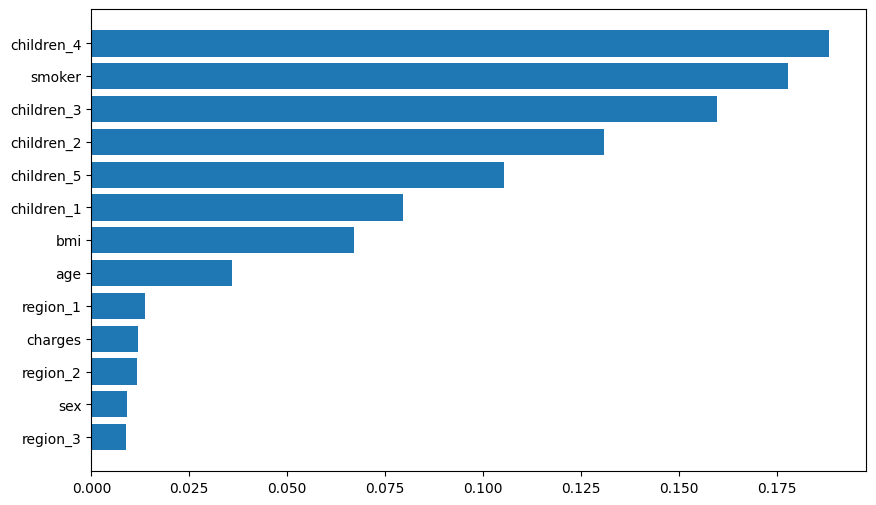

In [ ]:
#Extreme Gradient Boosting Classifier

XGB_model = XGBClassifier()
param_dist = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


XGB = XGB_model.fit(Train_X_std, Train_Y, eval_metric='logloss')#.best_estimator_
pred = XGB.predict(Test_X_std)
pred_prob = XGB.predict_proba(Test_X_std)

xgbf=pd.DataFrame(XGB.feature_importances_, index=Train_X_std.columns).sort_values(by=0)
plt.barh(xgbf.index,xgbf.values[:,0])
plt.show()

### Extra Trees Classifier

<<<----------------------------------- Evaluating Gradient Boosting (GB) ----------------------------------->>>

Accuracy = 90.2%
F1 Score = 90.2%

 Confusiton Matrix:
 [[115   9]
 [ 16 116]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       124
           1       0.93      0.88      0.90       132

    accuracy                           0.90       256
   macro avg       0.90      0.90      0.90       256
weighted avg       0.90      0.90      0.90       256



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


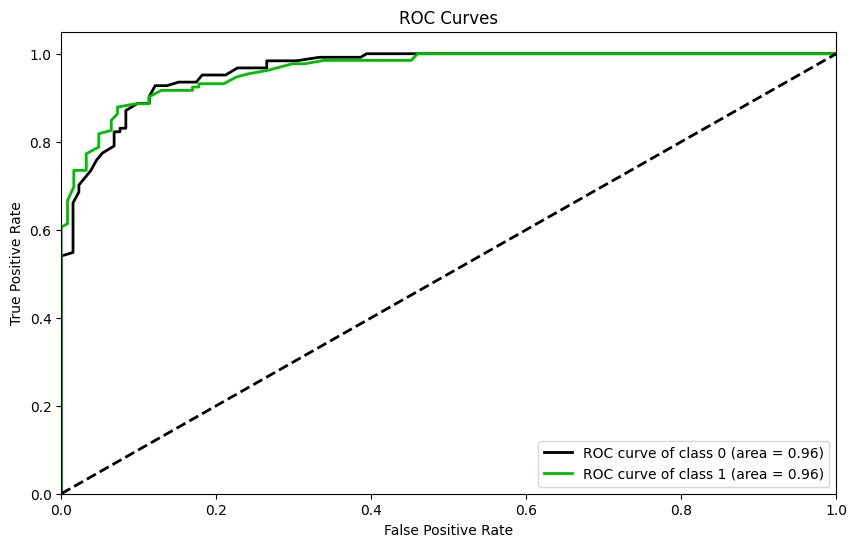

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

ET_model = ExtraTreesClassifier().fit(Train_X_std, Train_Y)

param_dist = {
    "n_estimators": [5, 20, 100, 500],
    "max_depth": [1, 3, 5, 7, 9]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

ET = ET_model.fit(Train_X_std, Train_Y)

pred = ET.predict(Test_X_std)
pred_prob = ET.predict_proba(Test_X_std)
Classification_Summary(pred, pred_prob, 6)


### Light BGM Classifier

[LightGBM] [Info] Number of positive: 506, number of negative: 514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 1020, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496078 -> initscore=-0.015687
[LightGBM] [Info] Start training from score -0.015687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 506, number of negative: 514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Ligh

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


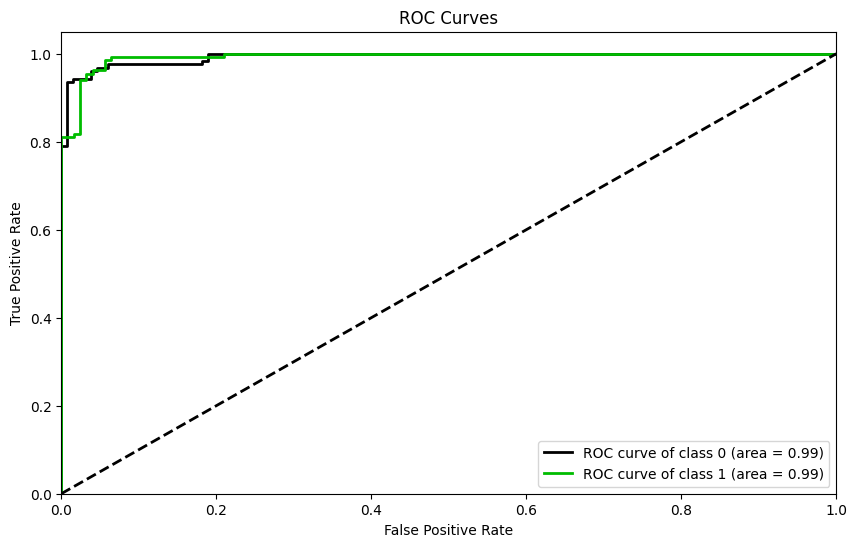

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RepeatedStratifiedKFold

LGBM_model = lgb.LGBMClassifier().fit(Train_X_std, Train_Y)

param_dist = {
    "n_estimators": [5, 20, 100, 500],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10, 100]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

LGBM = LGBM_model.fit(Train_X_std, Train_Y)

pred = LGBM.predict(Test_X_std)
pred_prob = LGBM.predict_proba(Test_X_std)
Classification_Summary(pred, pred_prob, 6)


### CatBoost  Calssifier

In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 3.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

CatBoost_model = CatBoostClassifier(iterations=1000, # Number of trees to grow
                                    depth=6,        # Maximum depth of each tree
                                    learning_rate=0.1, # Learning rate (shrinkage)
                                    loss_function='MultiClass',
                                    verbose=0)      # Verbosity level (0 - silent)

CatBoost = CatBoost_model.fit(Train_X_std, Train_Y)

pred = CatBoost.predict(Test_X_std)
pred_prob = CatBoost.predict_proba(Test_X_std)
Classification_Summary(pred, pred_prob, 6)


ModuleNotFoundError: No module named 'catboost'

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(Train_X_std.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(Train_X_std, Train_Y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(Test_X_std, Test_Y)
print('Test accuracy:', test_acc)

Epoch 1/50
13/13 [==============================] - 1s 24ms/step - loss: 1.5427 - accuracy: 0.3076 - val_loss: 1.3087 - val_accuracy: 0.6716
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 1.1075 - accuracy: 0.5956 - val_loss: 0.8835 - val_accuracy: 0.5784
Epoch 3/50
13/13 [==============================] - 0s 9ms/step - loss: 0.7778 - accuracy: 0.6544 - val_loss: 0.6340 - val_accuracy: 0.7451
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6009 - accuracy: 0.7304 - val_loss: 0.5217 - val_accuracy: 0.7647
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.5322 - accuracy: 0.7561 - val_loss: 0.4646 - val_accuracy: 0.7794
Epoch 6/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4923 - accuracy: 0.7831 - val_loss: 0.4138 - val_accuracy: 0.8186
Epoch 7/50
13/13 [==============================] - 0s 8ms/step - loss: 0.4668 - accuracy: 0.7929 - val_loss: 0.3994 - val_accuracy: 0.8088
Epoch 8/50
13/13 [=

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(256, activation='relu', input_shape=(Train_X_std.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(Train_X_std, Train_Y, epochs=150, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(Test_X_std, Test_Y)
print('Test accuracy:', test_acc)


Epoch 1/150
7/7 [==============================] - 3s 84ms/step - loss: 2.0165 - accuracy: 0.0159 - val_loss: 1.8642 - val_accuracy: 0.0196
Epoch 2/150
7/7 [==============================] - 0s 19ms/step - loss: 1.9424 - accuracy: 0.0650 - val_loss: 1.8296 - val_accuracy: 0.0686
Epoch 3/150
7/7 [==============================] - 0s 21ms/step - loss: 1.9025 - accuracy: 0.0919 - val_loss: 1.8040 - val_accuracy: 0.2206
Epoch 4/150
7/7 [==============================] - 0s 23ms/step - loss: 1.8709 - accuracy: 0.1446 - val_loss: 1.7824 - val_accuracy: 0.3578
Epoch 5/150
7/7 [==============================] - 0s 23ms/step - loss: 1.8412 - accuracy: 0.2132 - val_loss: 1.7617 - val_accuracy: 0.4510
Epoch 6/150
7/7 [==============================] - 0s 22ms/step - loss: 1.8142 - accuracy: 0.2696 - val_loss: 1.7408 - val_accuracy: 0.4853
Epoch 7/150
7/7 [==============================] - 0s 26ms/step - loss: 1.7749 - accuracy: 0.3223 - val_loss: 1.7181 - val_accuracy: 0.4951
Epoch 8/150
7/7 [===

### **METRICS**

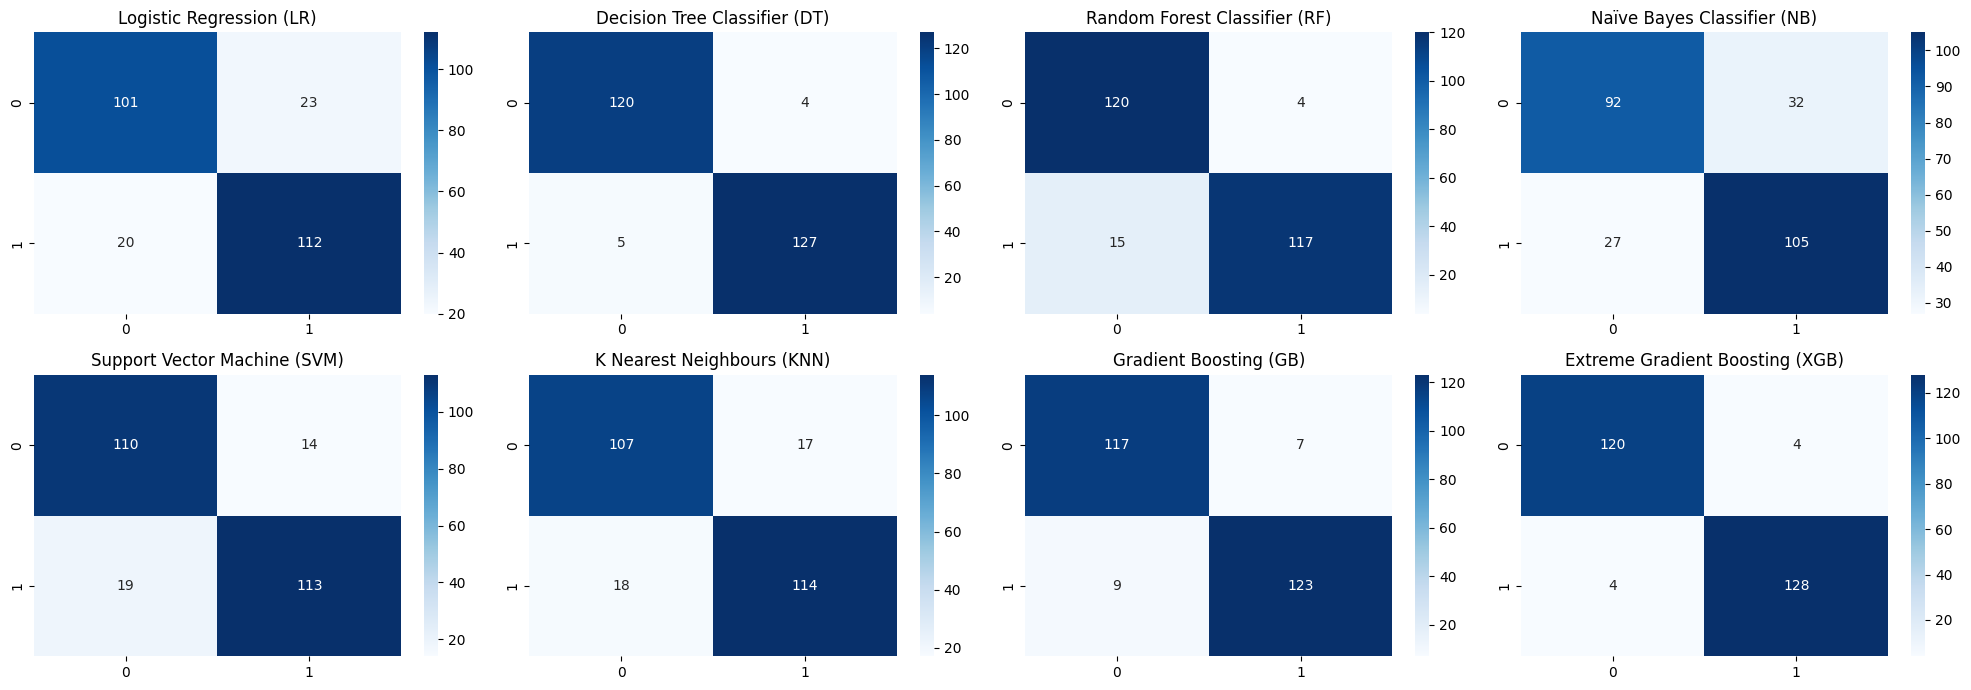

In [ ]:
#Plotting Confusion-Matrix of all the predictive Models

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')

def conf_mat_plot(all_models):
    plt.figure(figsize=[20,3.5*math.ceil(len(all_models)*len(labels)/14)])

    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/3),3,i+1)
        pred = all_models[i].predict(Test_X_std)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='Blues', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB,SVM,KNN,GB,XGB])

In [ ]:
#Comparing all the models Scores

print('\033[1mML Algorithms Comparison'.center(100))
plt.figure(figsize=[12,8])
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=95, cmap='Greens', fmt='.1f')
plt.show()


                                    ML Algorithms Comparison                                    


NameError: name 'plt' is not defined